## 딥러닝(MLP, Multilayer-perceptron)
- Fully connected layer 혹은 Deep Neural network 로도 불림
- 오늘(7/28, 월)은 딥러닝에 대한 개괄을 다루었고 특히 MLP에 대해 자세히 다룸

### 01 라이브러리, hyper-parameter

In [2]:
import torch
import torch.nn as nn # neural net의 약자인듯?
from torch.utils.data import DataLoader, Dataset, random_split # Dataloader, Dataset, random_split 불러오기

import numpy as np
import pandas as pd

from torchvision import transforms
from torchvision.datasets import FashionMNIST # FashionMNIST 데이터

from sklearn.datasets import load_diabetes
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classificification_data_path = "./sample_data/"

regression_data_info = load_diabetes()
regression_feature_names = regression_data_info.feature_names

test_data_ratio = 0.3
random_state = 0

classifier_input_size = 28 * 28
classifier_hidden_size1 = 512
classifier_hidden_size2 = 128
classifier_hidden_size3 = 32
classifier_output_size = 10

regressor_input_size = len(regression_feature_names)
regressor_hidden_size1 = 16
regressor_hidden_size2 = 32
regressor_hidden_size3 = 16
regressor_output_size = 1

learning_rate = 5e-3
epochs = 50
batch_size = 32

regression_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

### 02 Data load하는 class 정의

In [3]:
class ClassificationDataLoader:
    def __init__(self, data_path, batch_size):
        self.data_path = data_path
        self.batch_size = batch_size
        self.transform = transforms.ToTensor()

    def __call__(self, flag):
        if flag == "train":
            dataset = FashionMNIST(
                self.data_path, train=True, download=True, transform=self.transform
            )
        else:
            dataset = FashionMNIST(
                self.data_path, train=False, download=True, transform=self.transform
            )

        data_loader = DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=0,
        )

        return data_loader


class RegressionDataset(Dataset):
    def __init__(self, data_info, feature_names, random_state):
        self.data_info = data_info
        self.feature_names = feature_names
        self.random_state = random_state

        self.data_infos = self.get_data_infos()
        self.data, self.label = self.get_dataset()

    def get_data_infos(self):
        df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
        df["label"] = self.data_info.target
        return df

    def get_dataset(self):
        data, label = self.data_infos.drop(columns=["label"]), self.data_infos["label"]
        return data.to_numpy().astype(np.float32), label.to_numpy().astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


classification_loader = ClassificationDataLoader(
    classificification_data_path, batch_size
)
classification_train_loader = classification_loader("train")
classification_test_loader = classification_loader("test")

regression_dataset = RegressionDataset(
    regression_data_info, regression_feature_names, random_state
)
num_regression_train_data = int(len(regression_dataset) * (1 - test_data_ratio))
num_regression_test_data = len(regression_dataset) - num_regression_train_data

regression_train_dataset, regression_test_dataset = random_split(
    regression_dataset, [num_regression_train_data, num_regression_test_data]
)

regression_train_loader = DataLoader(
    regression_train_dataset, batch_size=batch_size, drop_last=False
)
regression_test_loader = DataLoader(
    regression_test_dataset, batch_size=batch_size, drop_last=False
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 172kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


### 03 DeepLearning 설계

In [4]:
class DeepNeuralNetwork(nn.Module):
    def __init__(
        self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size
    ):
        super(DeepNeuralNetwork, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
        )
        self.output_layer = nn.Linear(hidden_size3, output_size)

    def forward(self, data):
        data = self.prepare_input(data)
        feature = self.feature_extractor(data)
        result = self.output_layer(feature)
        return result

    def prepare_input(self, data):
        flattened_data = data.view(data.size(0), -1)
        return flattened_data


classifier = DeepNeuralNetwork(
    classifier_input_size,
    classifier_hidden_size1,
    classifier_hidden_size2,
    classifier_hidden_size3,
    classifier_output_size,
).to(device)
classifier_optimizer = torch.optim.SGD(
    classifier.parameters(), lr=learning_rate
)

regressor = DeepNeuralNetwork(
    regressor_input_size,
    regressor_hidden_size1,
    regressor_hidden_size2,
    regressor_hidden_size3,
    regressor_output_size,
).to(device)
regressor_optimizer = torch.optim.SGD(
    regressor.parameters(), lr=learning_rate
)

### 04 DeepLearning 모델 학습

In [5]:
class Trainer:
    def __init__(self, model, data_loader, optimizer, criterion, epochs, device):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.device = device

    def train(self):
        self.model.train()

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1} / {self.epochs}")
            for data, label in self.data_loader:
                self.optimizer.zero_grad()
                data, label = data.to(self.device), label.to(self.device)
                result = self.model(data)
                loss = self.criterion(result, label)

                loss.backward()
                self.optimizer.step()


classifier_trainer = Trainer(
    classifier,
    classification_train_loader,
    classifier_optimizer,
    classification_criterion,
    epochs,
    device,
)
classifier_trainer.train()

regressor_trainer = Trainer(
    regressor,
    regression_train_loader,
    regressor_optimizer,
    regression_criterion,
    epochs,
    device,
)
regressor_trainer.train()

Epoch 1 / 50
Epoch 2 / 50
Epoch 3 / 50
Epoch 4 / 50
Epoch 5 / 50
Epoch 6 / 50
Epoch 7 / 50
Epoch 8 / 50
Epoch 9 / 50
Epoch 10 / 50
Epoch 11 / 50
Epoch 12 / 50
Epoch 13 / 50
Epoch 14 / 50
Epoch 15 / 50
Epoch 16 / 50
Epoch 17 / 50
Epoch 18 / 50
Epoch 19 / 50
Epoch 20 / 50
Epoch 21 / 50
Epoch 22 / 50
Epoch 23 / 50
Epoch 24 / 50
Epoch 25 / 50
Epoch 26 / 50
Epoch 27 / 50
Epoch 28 / 50
Epoch 29 / 50
Epoch 30 / 50
Epoch 31 / 50
Epoch 32 / 50
Epoch 33 / 50
Epoch 34 / 50
Epoch 35 / 50
Epoch 36 / 50
Epoch 37 / 50
Epoch 38 / 50
Epoch 39 / 50
Epoch 40 / 50
Epoch 41 / 50
Epoch 42 / 50
Epoch 43 / 50
Epoch 44 / 50
Epoch 45 / 50
Epoch 46 / 50
Epoch 47 / 50
Epoch 48 / 50
Epoch 49 / 50
Epoch 50 / 50
Epoch 1 / 50


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2 / 50
Epoch 3 / 50
Epoch 4 / 50
Epoch 5 / 50
Epoch 6 / 50
Epoch 7 / 50
Epoch 8 / 50
Epoch 9 / 50
Epoch 10 / 50
Epoch 11 / 50
Epoch 12 / 50
Epoch 13 / 50
Epoch 14 / 50
Epoch 15 / 50
Epoch 16 / 50
Epoch 17 / 50
Epoch 18 / 50
Epoch 19 / 50
Epoch 20 / 50
Epoch 21 / 50
Epoch 22 / 50
Epoch 23 / 50
Epoch 24 / 50
Epoch 25 / 50
Epoch 26 / 50
Epoch 27 / 50
Epoch 28 / 50
Epoch 29 / 50
Epoch 30 / 50
Epoch 31 / 50
Epoch 32 / 50
Epoch 33 / 50
Epoch 34 / 50
Epoch 35 / 50
Epoch 36 / 50
Epoch 37 / 50
Epoch 38 / 50
Epoch 39 / 50
Epoch 40 / 50
Epoch 41 / 50
Epoch 42 / 50
Epoch 43 / 50
Epoch 44 / 50
Epoch 45 / 50
Epoch 46 / 50
Epoch 47 / 50
Epoch 48 / 50
Epoch 49 / 50
Epoch 50 / 50


### 05 시각화
- 학습 하면서 train_loss, validation_loss, train_accuracy, validation_accuracy가 변하는 경향을 시각화

In [10]:
import matplotlib.pyplot as plt

classifier_train_losses = []
classifier_train_accuracies = []

for epoch in range(epochs):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0

    for data, label in classification_train_loader:
        data, label = data.to(device), label.to(device)

        classifier_optimizer.zero_grad()
        output = classifier(data)
        loss = classification_criterion(output, label)
        loss.backward()
        classifier_optimizer.step()

        running_loss += loss.item()

        pred = output.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += label.size(0)

    avg_loss = running_loss / len(classification_train_loader)
    acc = correct / total
    classifier_train_losses.append(avg_loss)
    classifier_train_accuracies.append(acc)

    print(f"[{epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

[1/50] Loss: 0.2005, Accuracy: 0.9283
[2/50] Loss: 0.1971, Accuracy: 0.9285
[3/50] Loss: 0.1937, Accuracy: 0.9303
[4/50] Loss: 0.1912, Accuracy: 0.9313
[5/50] Loss: 0.1879, Accuracy: 0.9323
[6/50] Loss: 0.1849, Accuracy: 0.9341
[7/50] Loss: 0.1812, Accuracy: 0.9347
[8/50] Loss: 0.1794, Accuracy: 0.9349
[9/50] Loss: 0.1766, Accuracy: 0.9367
[10/50] Loss: 0.1732, Accuracy: 0.9384
[11/50] Loss: 0.1705, Accuracy: 0.9391
[12/50] Loss: 0.1674, Accuracy: 0.9395
[13/50] Loss: 0.1656, Accuracy: 0.9408
[14/50] Loss: 0.1634, Accuracy: 0.9418
[15/50] Loss: 0.1612, Accuracy: 0.9417
[16/50] Loss: 0.1586, Accuracy: 0.9429
[17/50] Loss: 0.1558, Accuracy: 0.9439
[18/50] Loss: 0.1526, Accuracy: 0.9458
[19/50] Loss: 0.1506, Accuracy: 0.9454
[20/50] Loss: 0.1471, Accuracy: 0.9466
[21/50] Loss: 0.1455, Accuracy: 0.9476
[22/50] Loss: 0.1435, Accuracy: 0.9489
[23/50] Loss: 0.1419, Accuracy: 0.9490
[24/50] Loss: 0.1407, Accuracy: 0.9497
[25/50] Loss: 0.1362, Accuracy: 0.9515
[26/50] Loss: 0.1358, Accuracy: 0.

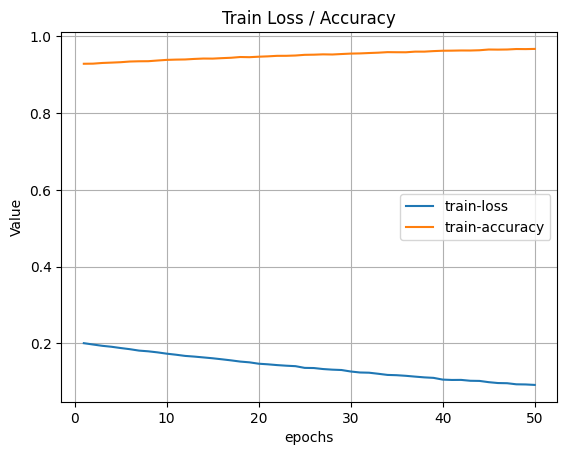

In [11]:
epochs_range = range(1, len(classifier_train_losses)+1)

plt.plot(epochs_range, classifier_train_losses, label='train-loss')
plt.plot(epochs_range, classifier_train_accuracies, label='train-accuracy')

plt.xlabel("epochs")
plt.ylabel("Value")
plt.title("Train Loss / Accuracy")
plt.legend()
plt.grid(True)
plt.show()